In [35]:
import time
import matplotlib.pyplot as plt 
from tqdm import trange
import numpy as np
import torch
from torch import nn
from torch.nn.functional import conv2d 
from scipy.io import loadmat
from scipy.stats import zscore
dat = loadmat("inkrefcap7_run01_thal_crop_01102024.mat", squeeze_me=True)

import nn_prediction
import imp
imp.reload(nn_prediction)

<module 'nn_prediction' from '/Users/beverlysetzer/Documents/scripts/nn_prediction.py'>

### data

In [36]:
Y = dat["behav"].T.copy()[:,np.newaxis].astype("float32")
X = dat["data_mat"].copy().astype("float32")
X = zscore(X, axis=0).squeeze().T
print(Y.shape)
print(X.shape)

(7951, 1)
(7951, 911)


In [37]:
n_time = X.shape[0]
n_in = X.shape[1]
n_out = Y.shape[1]
print(n_in, n_out)

911 1


### split data

In [38]:
itrain, itest = nn_prediction.split_traintest(n_time, frac=0.4, pad=20)
X_train, Y_train = X[itrain.flatten()], Y[itrain.flatten()]
X_test, Y_test = X[itest.flatten()], Y[itest.flatten()]

### linear regression prediction

Use linear regression to perform the prediction, predict $Y$ from $X$. $X$ is time by n_in, $Y$ is time by n_out. If you want to regularize the linear regression:

$$ A = (X_\text{train}^\top X_\text{train} + \lambda I)^{-1} (X_\text{train}^\top Y_\text{train})$$

Then the prediction on time points is:

$$ \hat Y_\text{test} = X_\text{test} A $$

In [39]:
# regularized linear regression
XtX = X_train.T @ X_train
XtY = X_train.T @ Y_train
lam = 1e3 # regularizer

# add a ridge regularizer to the linear regression with parameter "lam" 
XtX = XtX + lam * np.eye(n_in)

# regression matrix
A = np.linalg.solve(XtX, XtY)

# prediction on test data
Y_pred_lin = X_test @ A

# variance explained per area
residual = ((Y_pred_lin - Y_test)**2).sum(axis=0)
varexp_areas_lin = 1 - residual / (Y_test**2).sum(axis=0)

# overall varexp
varexp_lin = 1 - residual.sum() / (Y_test**2).sum()

print(f"overall variance explained = {varexp_lin}")

overall variance explained = -0.18912231662727663


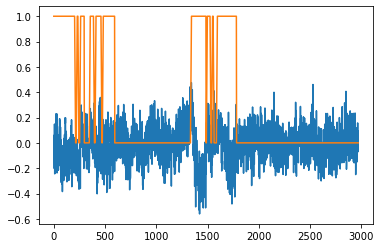

In [40]:
np.shape(Y_test)
plt.plot(Y_pred_lin)
plt.plot(Y_test)

### network

In [41]:
device = torch.device("cuda")
net = nn_prediction.PredictionNetwork(n_in=n_in, n_out=n_out, kernel_size=51)
#net.to(device)

In [42]:
### split data and put on GPU
x_train = torch.from_numpy(X[itrain])#.to(device)
y_train = torch.from_numpy(Y[itrain])#.to(device)
x_test = torch.from_numpy(X[itest])#.to(device)
y_test = torch.from_numpy(Y[itest])#.to(device)

### train model

In [43]:
# reinitialize model to reset weights
net = nn_prediction.PredictionNetwork(n_in=n_in, n_out=n_out, kernel_size=51, identity=False)
#net.to(device)


### training params
learning_rate = 1e-4
weight_decay = 1e-4 #L2 regularization
n_iter = 300
annealing_steps = 3
smoothing_penalty = 0.5

anneal_epochs = n_iter - 50*np.arange(1, annealing_steps+1) if n_iter > 199 else [-1]
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, 
                            weight_decay=weight_decay)#, momentum=0.9)
tic = time.time()
n_batches = x_train.shape[0]

### optimize all parameters with optimizer
for epoch in range(n_iter):
    net.train()
    if epoch in anneal_epochs:
        print('annealing learning rate')
        optimizer.param_groups[0]['lr'] /= 10.
    np.random.seed(epoch)
    rperm = np.random.permutation(n_batches)
    train_loss = 0
    for n in rperm:
        y_pred = net(x_train[n].unsqueeze(0))[0]
        loss = ((y_pred - y_train[n].unsqueeze(0))**2).mean()
        loss += smoothing_penalty * (torch.diff(net.core.features[1].weight)**2).sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= n_batches

    # compute test loss and test variance explained
    if epoch%20==0 or epoch==n_iter-1:
        net.eval()
        with torch.no_grad():
            y_pred = net(x_test)[0]
            y_pred = y_pred.reshape(-1, y_pred.shape[-1])
            tl = ((y_pred - y_test.reshape(-1, y_pred.shape[-1]))**2).mean()
            ve = 1 - tl / ((y_test.reshape(-1, y_pred.shape[-1]) - y_test.mean(axis=(0,1)))**2).mean()
        print(f'epoch {epoch}, train loss {train_loss:.4f}, test loss {tl.item():.4f}, varexp {ve.item():.4f}, time {time.time()-tic:.1f}s')
        

epoch 0, train loss 0.7099, test loss 0.2534, varexp -0.2710, time 0.7s
epoch 20, train loss 0.3199, test loss 0.0971, varexp 0.5128, time 10.2s
epoch 40, train loss 0.1910, test loss 0.0914, varexp 0.5416, time 20.1s
epoch 60, train loss 0.1265, test loss 0.0912, varexp 0.5425, time 29.8s
epoch 80, train loss 0.0836, test loss 0.0954, varexp 0.5213, time 40.3s
epoch 100, train loss 0.0547, test loss 0.0917, varexp 0.5399, time 50.7s
epoch 120, train loss 0.0350, test loss 0.0958, varexp 0.5196, time 61.1s
epoch 140, train loss 0.0222, test loss 0.1010, varexp 0.4933, time 71.5s
annealing learning rate
epoch 160, train loss 0.0173, test loss 0.0982, varexp 0.5072, time 81.6s
epoch 180, train loss 0.0164, test loss 0.0992, varexp 0.5022, time 91.9s
annealing learning rate
epoch 200, train loss 0.0156, test loss 0.1000, varexp 0.4983, time 102.3s
epoch 220, train loss 0.0155, test loss 0.1001, varexp 0.4978, time 112.8s
epoch 240, train loss 0.0154, test loss 0.1002, varexp 0.4974, time 

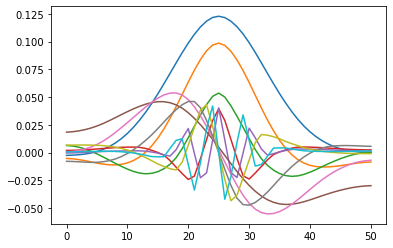

In [44]:
plt.plot(net.core.features.wavelet0.weight.squeeze().detach().numpy().T)



In [45]:
device = torch.device("cuda")
net2 = nn_prediction.PredictionNetwork(n_in=n_in, n_out=n_out, kernel_size=51)
#net.to(device)


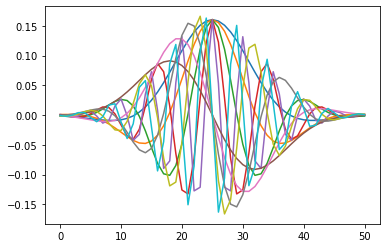

In [46]:
plt.plot(net2.core.features.wavelet0.weight.squeeze().detach().numpy().T)


In [47]:
net

PredictionNetwork(
  (core): Core(
    (features): Sequential(
      (linear0): Sequential(
        (0): Linear(in_features=911, out_features=911, bias=True)
      )
      (wavelet0): Conv1d(1, 10, kernel_size=(51,), stride=(1,), padding=(25,), bias=False)
      (latent): Sequential(
        (0): Linear(in_features=9110, out_features=20, bias=True)
      )
    )
  )
  (readout): Readout(
    (linear): Sequential(
      (linear): Linear(in_features=20, out_features=1, bias=True)
    )
  )
)

In [48]:
Y_pred = y_pred.cpu().numpy().reshape(-1, y_pred.shape[-1])
Y_test = y_test.cpu().numpy().reshape(-1, y_pred.shape[-1])

# variance explained per area
residual = ((Y_pred - Y_test)**2).sum(axis=0)
varexp_areas = 1 - residual / (Y_test**2).sum(axis=0)


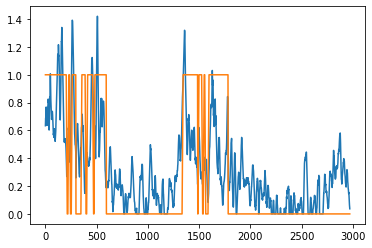

In [49]:
plt.plot(Y_pred)
plt.plot(Y_test)